In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack, trim_stack
from pyPSFstack.diversities import ZDiversity, PDiversity
from pyPSFstack.cost_functions import CostGaussian

from pyPSFstack_torch.psf_modules import IncoherentPSF#,ScalarPhaseAberrations,\
    # ScalarPSF

In [27]:
from pyPSFstack_torch.functions import crop_center

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
distance_coverslip = 30
wavelength = 525

In [3]:

angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/4

model_measured2 = IncoherentPSF(
                 pol_analyzer='quarter2pol',
                 angle_list=np.arange(angle_i,angle_f+angle_step,angle_step),
                 aperture_size=numerical_aperture / nf, 
                 computation_size=wavelength*magnification/(cam_pixel_size*nf), 
                 N_pts=128, 
                 ni=1.33, 
                 nf=1.518, 
                 delta=0.1,
                 c=1.24*np.pi,
                 jmax=[15]*5, 
                 index_convention='fringe'
                 )

/opt/anaconda3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/rodrigo/Documents/Research/CHIDO/pyPSFstack/pyPSFstack_torch/sources.py:63: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/Copy.cpp:244.)
  aperture = self.ur2.type(torch.float) <= aperture_size**2


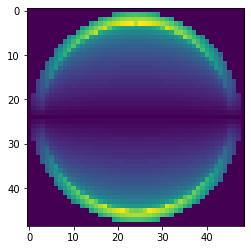

In [11]:
plt.imshow(np.abs(model_measured2.source.green[...,0,2]))

In [14]:
zi = -300; zf = 300; z_step = 100
z_list = torch.arange(zi,zf+z_step,z_step) / wavelength

In [15]:
with torch.no_grad():
    model_measured2.eval()
    data = model_measured2(z_list, 40)

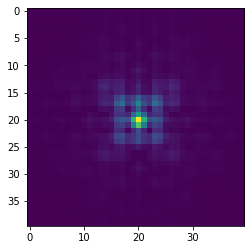

In [18]:
plt.imshow(data[...,5,0])

In [19]:
import torch.fft as fft

In [20]:
model_measured2.source.green.shape

torch.Size([49, 49, 2, 3])

In [21]:

test_psf = fft.fftshift(
            fft.fft2(fft.ifftshift(model_measured2.source.green,dim=(0,1)),
                     dim=(0,1),
                     s=(128,128)),
            dim=(0,1))

In [22]:
test_psf.shape

torch.Size([128, 128, 2, 3])

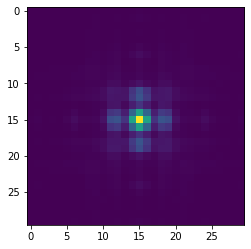

In [28]:
plt.imshow(crop_center(torch.sum(torch.abs(test_psf)**2,dim=(-2,-1)),30))

In [10]:
with torch.no_grad():
    model_measured.eval()
    data = model_measured(torch.range(-10,10,1))

NameError: name 'model_measured' is not defined

In [ ]:
ur, _ = polar_mesh()

In [17]:
lr = 1e-1
n_epochs = 100

loss_fn = nn.MSELoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(
    model_retrieve.parameters(), 
    lr=lr
)
loss_evol =[]
for epoch in range(n_epochs):
    # What is this?!?
    model_retrieve.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model_retrieve(torch.range(-10,10,1))
    
    loss = loss_fn(data, yhat)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model_retrieve.state_dict())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


OrderedDict([('aberrations.c_W', tensor([ 0.0857,  0.1127,  0.1364, -0.0905,  0.2346,  0.1567, -0.0095, -0.0996]))])


In [18]:
print(model_measured.state_dict())

OrderedDict([('aberrations.c_W', tensor([ 0.0853,  0.1123,  0.1360, -0.0904,  0.2344,  0.1565, -0.0093, -0.0995]))])


In [22]:
loss_evol = [loss_evol[j].item() for j in range(len(loss_evol))]

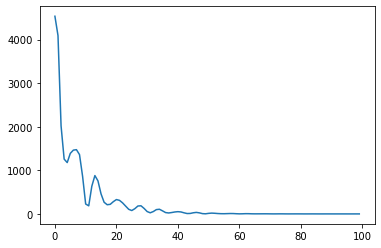

In [23]:
plt.plot(loss_evol)

In [15]:
crop_psfs=crop_center(psfs, 30)

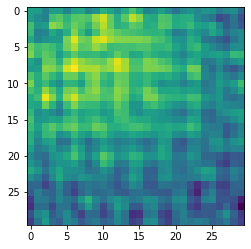

In [14]:
plt.imshow(data[...,18])

In [22]:
model2.state_dict()

OrderedDict([('aberrations.c_W',
              tensor([ 0.9167, -2.6081,  0.0638, -0.2863, -0.0164,  3.3121,  0.2280,  1.1234]))])

In [11]:
torch.randn(10)

tensor([ 0.2148,  0.8494,  0.4887,  0.1341, -1.0543,  0.7751,  0.3746,  0.2624,
        -0.8381, -1.4216])

In [12]:
torch.reshape(torch.tensor([-0.5,0,0.5]),(1,1,-1))*(torch.range(1,16).reshape((4,4)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 2

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

In [24]:
torch.tensor(2)


[autoreload of pyPSFstack_torch.zernike_functions failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/rodrigo/Documents/Research/CHIDO/pyPSFstack/pyPSFstack_torch/zernike_functions.py", line 5, in <module>
    from .functions import cart2pol
  File "/Users/rodrigo/Documents/

tensor(2)

In [27]:
x =torch.tensor(1.2, dtype=torch.cfloat)

In [28]:
(1-x)**(1/2)

tensor(0.+0.4472j)